<a href="https://colab.research.google.com/github/HugoMagos0725/Analisis_de_datos/blob/main/Tarea3_Ajuste_de_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FCFM-BUAP, 2023**

## Proyecto: Ajuste de parametros
Nombre: Hugo Cuautle Magos

Matricula: 201847053

Materia: Análisis de datos

# Problema 1 

El archivo "Puebla_pos.cvs" son datos de los casos registrados (nuevos casos) para Puebla, reportados por la secretaría de salud. 

Carga los datos y grafica


In [1]:
import pandas as pd

from google.colab import drive 
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/Puebla_pos.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FECHA_SINTOMAS,positivo
0,2020-03-02,1
1,2020-03-05,2
2,2020-03-08,3
3,2020-03-09,4
4,2020-03-10,3
...,...,...
673,2022-01-09,493
674,2022-01-10,556
675,2022-01-11,287
676,2022-01-12,149


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime 

df1=list(range(len(df['FECHA_SINTOMAS'])))

for i in df1:
  st=df['FECHA_SINTOMAS'][i]
  df1[i]=datetime.strptime(st,'%Y-%m-%d')

df['FECHA_SINTOMAS']=df1

In [3]:
import numpy as np

df['infectados']=np.cumsum(df['positivo'])
df

,FECHA_SINTOMAS,positivo,infectados
0,2020-03-02,1,1
1,2020-03-05,2,3
2,2020-03-08,3,6
3,2020-03-09,4,10
4,2020-03-10,3,13
...,...,...,...
673,2022-01-09,493,139030
674,2022-01-10,556,139586
675,2022-01-11,287,139873
676,2022-01-12,149,140022


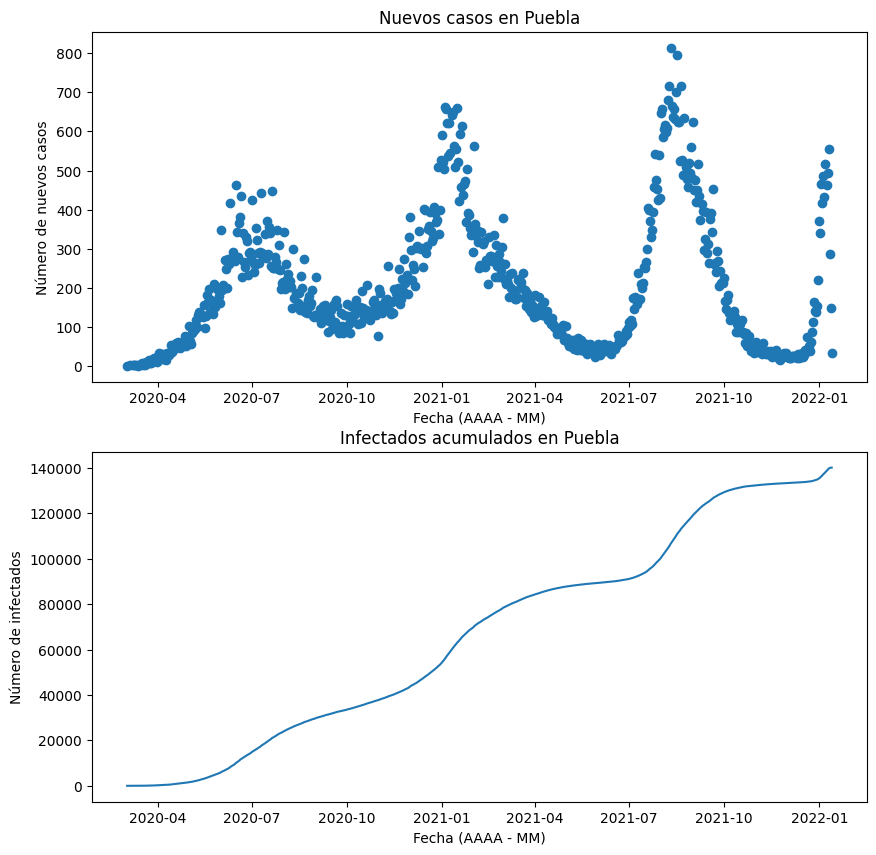

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.title('Nuevos casos en Puebla')
plt.xlabel('Fecha (AAAA - MM)')
plt.ylabel('Número de nuevos casos')
plt.scatter(df['FECHA_SINTOMAS'],df['positivo'])
plt.subplot(2, 1, 2)
plt.title('Infectados acumulados en Puebla')
plt.xlabel('Fecha (AAAA - MM)')
plt.ylabel('Número de infectados')
plt.plot(df['FECHA_SINTOMAS'],df['infectados'])
plt.show()

# Problema 2 

Ajustar la primera ola con mínimos cuadrados. 

In [5]:
ind_inf=list(df['FECHA_SINTOMAS'].astype(str)).index('2020-04-10')
ind_sup=list(df['FECHA_SINTOMAS'].astype(str)).index('2020-10-01')
ind=ind_sup-ind_inf

primera_ola=df['positivo'][ind_inf:ind_sup].astype(int)
t = np.linspace(0, ind,ind)
primera_ola.index=list(range(len(primera_ola)))
print(primera_ola)

0       35
1       35
2       28
3       53
4       36
      ... 
169    104
170     84
171    130
172     97
173     90
Name: positivo, Length: 174, dtype: int64


In [6]:
from scipy import optimize
from scipy.integrate import odeint


def costo(x):
  b=x[0]
  g=x[1]
  def SIR(y,t,b,g):
    S=y[0]
    I=y[1]
    R=y[2]
    cum=y[3]

    N=S+I+R

    dS=-b*S*I/N
    dI=b*S*I/N-g*I
    dR=g*I
    dcum=b*S*I/N
    return np.array([dS,dI,dR,dcum])

  y0=[sum(primera_ola)-primera_ola[0],primera_ola[0],0,primera_ola[0]]
  model_pred=odeint(SIR,y0,t,args=(b,g))

  c=sum(np.array(primera_ola-model_pred[:,1])**2)
  return c

optimize.minimize(costo,[0.1,0.1],method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 415247.9425888533
             x: [ 2.947e-01  2.558e-01]
           nit: 63
          nfev: 124
 final_simplex: (array([[ 2.947e-01,  2.558e-01],
                       [ 2.947e-01,  2.558e-01],
                       [ 2.947e-01,  2.558e-01]]), array([ 4.152e+05,  4.152e+05,  4.152e+05]))

In [7]:
def SIR(y,t):

    b=0.2947
    g=0.2558

    S=y[0]
    I=y[1]
    R=y[2]
    cum=y[3]

    N=S+I+R

    dS=-b*S*I/N
    dI=b*S*I/N-g*I
    dR=g*I
    dcum=b*S*I/N
    return np.array([dS,dI,dR,dcum])

y0=[sum(primera_ola)-primera_ola[0],primera_ola[0],0,primera_ola[0]]

model_pred=odeint(SIR,y0,t)

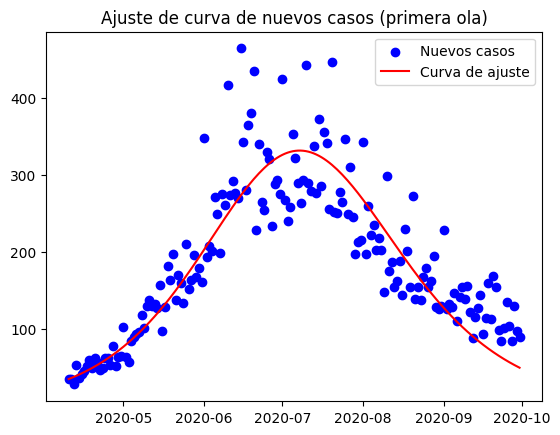

In [8]:
plt.title('Ajuste de curva de nuevos casos (primera ola)')
plt.scatter(df['FECHA_SINTOMAS'][ind_inf:ind_sup],df['positivo'][ind_inf:ind_sup],color='b')
plt.plot(df['FECHA_SINTOMAS'][ind_inf:ind_sup],model_pred[:,1],color='r')
plt.legend(['Nuevos casos','Curva de ajuste'])
plt.show()

# Problema 3 

Ajustar la segunda ola con  una cadena de Monte Carlo y dar intervalos de confianza para los parámetros. 

In [9]:
ind_inf2=ind_sup
ind_sup2=list(df['FECHA_SINTOMAS'].astype(str)).index('2021-05-15')
ind2=ind_sup2-ind_inf2

infected=df['positivo'][ind_inf2:ind_sup2].astype(int)
infected.index=list(range(len(infected)))
days=list(range(len(infected)))
print(infected)

0      158
1      129
2      107
3       86
4      155
      ... 
221     68
222     41
223     72
224     57
225     42
Name: positivo, Length: 226, dtype: int64


In [10]:
sigma_gamma = 0.0001;
sigma_beta = 0.0001
gamma = 0.18
beta = 0.19

like=0.0000000001
loglike=np.log(like)
Number_of_steeps = 11000
Burn_in_Time = 1000
mcmc_file_name = "mcmc.dat"

In [11]:
def PoissonLikelihood(dat, model_prediction):
	loglike=0.0
	for x, L in zip(dat, model_prediction):
		if(L>0.0):
			loglike = loglike - L + x*np.log(L)
	return loglike
		
def SIR(y,t,gamma,beta):
	S=y[0]
	I=y[1]
	R=y[2]
	N=S+I+R
	
	dS = -beta * S*I/N
	dI = beta * S*I/N - gamma*I
	dR = gamma*I
	return np.array([dS,dI,dR])

In [12]:
file_h = open(mcmc_file_name,"w+",buffering=1)
file_h.write('gamma,beta,log_likelihood\n')
random=0

for i in range(Number_of_steeps):
	gamma_try = np.random.normal(gamma, sigma_gamma)
	while (gamma_try < 0.0):
		gamma_try = np.random.normal(gamma, sigma_gamma)
	beta_try = np.random.normal(beta, sigma_beta)
	while (beta_try < 0.0):
		beta_try = np.random.normal(beta, sigma_beta)
		
	def model(y,t):
		return SIR(y,t,gamma_try,beta_try)
		
	y0 = np.array([sum(infected)-infected[0],infected[0],0.])
	model_prediction = odeint(model, y0, days)
	
	loglike_try = PoissonLikelihood(infected,model_prediction[:,1])
	
	if (loglike_try < loglike):
		random = np.random.uniform(0.0,1.0)
		accepted = np.exp(loglike_try - loglike)
	else:
		accepted = 1.
		
	if ( random < accepted):
		gamma = gamma_try
		beta = beta_try
		loglike = loglike_try

	if(i>Burn_in_Time):
		line = '{} , {} , {} \n'.format(gamma,beta,loglike)
		file_h.write(line)

file_h.close()

In [13]:
MCMC = pd.read_csv(mcmc_file_name)
MCMC.head()

,gamma,beta,log_likelihood
0,0.178446,0.196784,253820.323814
1,0.178446,0.196784,253820.323814
2,0.178446,0.196784,253820.323814
3,0.178495,0.196773,253820.172345
4,0.178495,0.196773,253820.172345


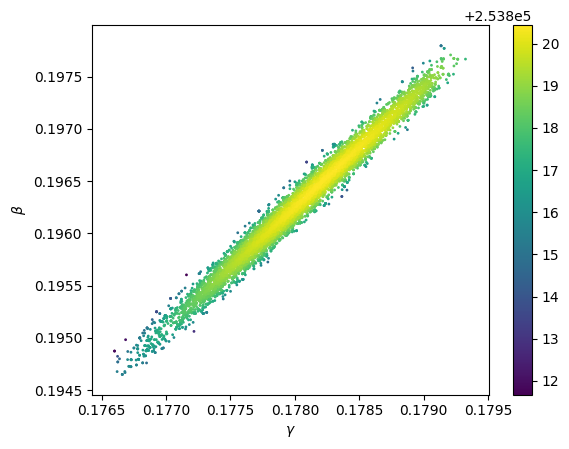

In [14]:
plt.scatter(x=MCMC.gamma,y=MCMC.beta,c=MCMC.log_likelihood,s=1)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.xlim([0.999*min(MCMC.gamma),1.001*max(MCMC.gamma)])
plt.ylim(0.999*min(MCMC.beta),1.001*max(MCMC.beta))
plt.show()

In [15]:
df1 = MCMC.drop_duplicates()
print(df1.shape)
max_like = df1['log_likelihood'].max()

best_parameters = df1[df1['log_likelihood']==max_like]
gamma_best = best_parameters['gamma'].values[0]
beta_best = best_parameters['beta'].values[0]
print(gamma_best)
print(beta_best)
MCMC.quantile([0.05,0.95])

(5441, 3)
0.1782261618138643
0.1965113296258208


,gamma,beta,log_likelihood
0.05,0.177226,0.195352,253817.349037
0.95,0.178899,0.197296,253820.381115


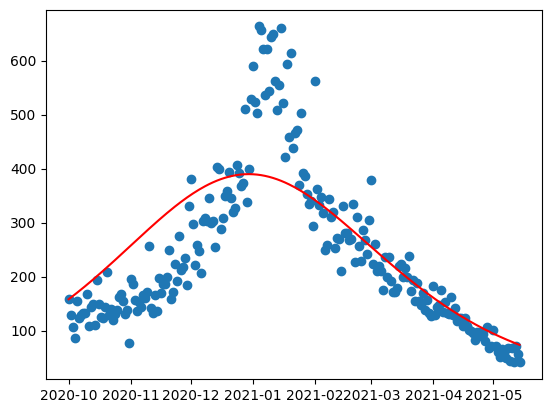

In [16]:
y0 = np.array([sum(infected)-infected[0],infected[0],0.])
def model(y,t):
		return SIR(y,t,gamma_best,beta_best)

time = np.linspace(0,ind2,ind2)
y = odeint(model,y0,time)
Model_Infected= y[:,1]

plt.plot(df['FECHA_SINTOMAS'][ind_inf2:ind_sup2],Model_Infected,color='r')
plt.scatter(df['FECHA_SINTOMAS'][ind_inf2:ind_sup2],infected)
plt.show()

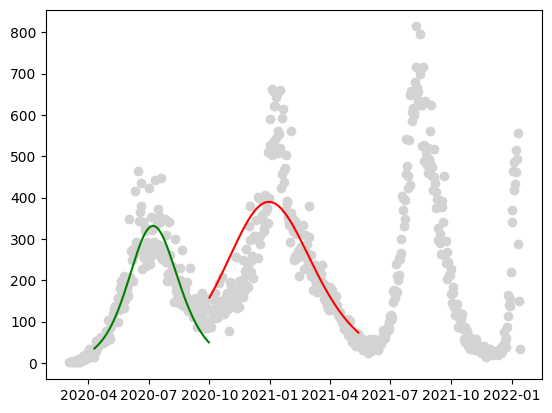

In [17]:
plt.scatter(df['FECHA_SINTOMAS'],df['positivo'],color='lightgray')
plt.plot(df['FECHA_SINTOMAS'][ind_inf2:ind_sup2],Model_Infected,color='r')
plt.plot(df['FECHA_SINTOMAS'][ind_inf:ind_sup],model_pred[:,1],color='g')
#plt.scatter(df['FECHA_SINTOMAS'][ind_inf2:ind_sup2],infected)
plt.show()

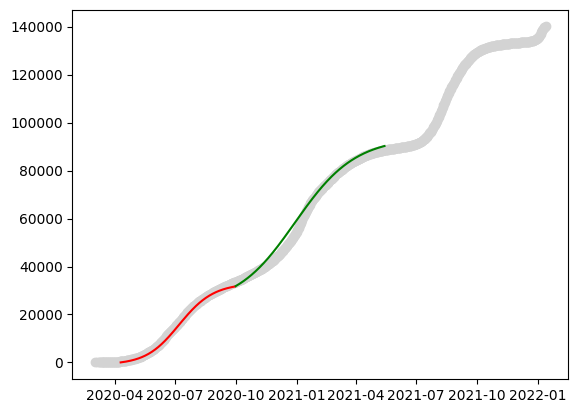

In [36]:

plt.scatter(df['FECHA_SINTOMAS'],df['infectados'],color='lightgray')
plt.plot(df['FECHA_SINTOMAS'][ind_inf:ind_sup],np.cumsum(model_pred[:,1]),color='r')
plt.plot(df['FECHA_SINTOMAS'][ind_inf2:ind_sup2],np.cumsum(Model_Infected)+sum(model_pred[:,1]),color='g')